In [2]:
# ============================================
# 1. Setup: copy cleaned data
# ============================================

import numpy as np
import pandas as pd

# Start from the outlier-handled dataframe
df_fe = pd.read_csv("loan_default_processed.csv")

print("Shape before feature engineering:", df_fe.shape)

# ============================================
# 2. Time-based features from Application_Date
# ============================================

# Ensure datetime
df_fe["Application_Date"] = pd.to_datetime(df_fe["Application_Date"], errors="coerce")

# Calendar features
df_fe["App_Year"] = df_fe["Application_Date"].dt.year
df_fe["App_Month"] = df_fe["Application_Date"].dt.month
df_fe["App_Quarter"] = df_fe["Application_Date"].dt.quarter

# Relative month index (loan vintage)
year_month = df_fe["Application_Date"].dt.to_period("M")
min_ym = year_month.min()
df_fe["App_Vintage"] = (year_month - min_ym).apply(lambda p: p.n)

# ============================================
# 3. Risk bands and customer profile features
# ============================================

# Age bands (simple retail banking style)
age_bins = [20, 30, 40, 50, 60, 70]
age_labels = ["20–29", "30–39", "40–49", "50–59", "60–69"]
df_fe["Age_Band"] = pd.cut(df_fe["Age"], bins=age_bins, labels=age_labels, include_lowest=True)

# Credit score bands (typical risk buckets)
credit_bins = [0, 680, 700, 720, 740, 800, np.inf]
credit_labels = ["<680", "680–699", "700–719", "720–739", "740–799", "800+"]
df_fe["Credit_Band"] = pd.cut(df_fe["Credit_Score"], bins=credit_bins,
                              labels=credit_labels, include_lowest=True)

# Employment length buckets (short vs stable history)
emp_map = {
    "< 1 year": "0–1 yr",
    "1 year": "0–1 yr",
    "2 years": "2–3 yrs",
    "3 years": "2–3 yrs",
    "4 years": "4–5 yrs",
    "5 years": "4–5 yrs",
    "6 years": "6–9 yrs",
    "7 years": "6–9 yrs",
    "8 years": "6–9 yrs",
    "9 years": "6–9 yrs",
    "10+ years": "10+ yrs"
}
df_fe["Employment_Tenure_Band"] = df_fe["Employment_Status"].map(emp_map).fillna("Other")

# Past default history flag
df_fe["Has_Past_Defaults"] = (df_fe["Past_Defaults"] > 0).astype(int)

# High DTI and low affordability flags (early risk signals)
df_fe["High_DTI_Flag"] = (df_fe["DTI"] > 0.6).astype(int)
df_fe["Low_Affordability_Flag"] = (df_fe["Affordability_Score"] < 85).astype(int)

# 4. Categorical normalisation / standardisation


# Standardise text casing for robustness
cat_cols_raw = [
    "Employment_Status", "Marital_Status", "Education_Level",
    "Property_Ownership", "Loan_Purpose", "Co_Applicant",
    "Approval_Channel", "Region"
]

for col in cat_cols_raw:
    if col in df_fe.columns:
        df_fe[col] = (
            df_fe[col]
            .astype(str)
            .str.strip()
        )


# 5. Define modelling dataset and column groups


target_col = "Defaulted"
id_cols = ["Customer_ID"]
leakage_cols = ["Approval_Status", "Application_Date"]  # raw date + status not used directly

# Drop identifiers and obvious leakage columns
drop_cols = id_cols + leakage_cols
df_model = df_fe.drop(columns=drop_cols)

# Identify final numeric and categorical feature lists
numeric_features = df_model.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_features = [c for c in numeric_features if c != target_col]

categorical_features = df_model.select_dtypes(include=["object", "category"]).columns.tolist()

print("Model dataframe shape:", df_model.shape)
print("\nNumeric features (sample):", numeric_features[:10])
print("\nCategorical features (sample):", categorical_features[:10])

# Quick check
df_model.head()

Shape before feature engineering: (987548, 25)
Model dataframe shape: (987548, 31)

Numeric features (sample): ['Age', 'Income', 'Annual_Expenses', 'Loan_Amount', 'Loan_Term_Months', 'Credit_Score', 'Past_Defaults', 'DTI', 'Income_Loan_Ratio', 'Monthly_Installment']

Categorical features (sample): ['Employment_Status', 'Marital_Status', 'Education_Level', 'Property_Ownership', 'Loan_Purpose', 'Co_Applicant', 'Approval_Channel', 'Region', 'Age_Band', 'Credit_Band']


,Age,Income,Annual_Expenses,Loan_Amount,Loan_Term_Months,Credit_Score,Employment_Status,Marital_Status,Education_Level,Property_Ownership,...,App_Month,App_Year,App_Quarter,App_Vintage,Age_Band,Credit_Band,Employment_Tenure_Band,Has_Past_Defaults,High_DTI_Flag,Low_Affordability_Flag
0,59,55000.0,33034.0,3600,36,679,10+ years,Married,Diploma,MORTGAGE,...,12,2015,4,40,50–59,<680,10+ yrs,0,1,0
1,49,65000.0,28524.0,24700,36,719,10+ years,Married,Diploma,MORTGAGE,...,12,2015,4,40,40–49,700–719,10+ yrs,1,0,0
2,35,104433.0,36104.0,10400,60,699,3 years,Single,Degree,MORTGAGE,...,12,2015,4,40,30–39,680–699,2–3 yrs,1,0,0
3,63,180000.0,97864.0,20000,36,684,10+ years,Divorced,Degree,MORTGAGE,...,12,2015,4,40,60–69,680–699,10+ yrs,0,0,0
4,28,85000.0,50128.0,20000,36,709,10+ years,Divorced,Masters,MORTGAGE,...,12,2015,4,40,20–29,700–719,10+ yrs,1,0,0


In [3]:
# =========================================
# 1. Train / Validation / Test Split
# =========================================
from sklearn.model_selection import train_test_split

target_col = "Defaulted"

# Features and target
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

# 60% train, 20% val, 20% test (all stratified on Defaulted)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    test_size=0.25,      # 0.25 of 0.8 = 0.2 of total → 60/20/20
    stratify=y_trainval,
    random_state=42,
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

# =========================================
# 2. Identify numeric and categorical features
# =========================================
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

# =========================================
# 3. Preprocessing Pipelines
#    - Scale numeric features
#    - One-hot encode categoricals
# =========================================
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

# Quick sanity check: transform a small batch
X_train_sample = X_train.head(100)
X_train_processed_sample = preprocessor.fit_transform(X_train_sample)
print("Processed sample shape:", X_train_processed_sample.shape)

# =========================================
# 4. Baseline modelling skeleton (logistic regression)
#    – we will refine / swap models in the next step
# =========================================
from sklearn.linear_model import LogisticRegression

baseline_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            n_jobs=-1
        ))
    ]
)

baseline_clf.fit(X_train, y_train)
print("Baseline model fitted on training data.")

Train shape: (592528, 30)
Validation shape: (197510, 30)
Test shape: (197510, 30)
Numeric features: ['Age', 'Income', 'Annual_Expenses', 'Loan_Amount', 'Loan_Term_Months', 'Credit_Score', 'Past_Defaults', 'DTI', 'Income_Loan_Ratio', 'Monthly_Installment', 'Loan_to_Income_Ratio', 'Affordability_Score', 'App_Vintage', 'Has_Past_Defaults', 'High_DTI_Flag', 'Low_Affordability_Flag']
Categorical features: ['Employment_Status', 'Marital_Status', 'Education_Level', 'Property_Ownership', 'Loan_Purpose', 'Co_Applicant', 'Approval_Channel', 'Region', 'Age_Band', 'Credit_Band', 'Employment_Tenure_Band']
Processed sample shape: (100, 74)
Baseline model fitted on training data.


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


=== LogisticRegression ===
ROC AUC (val): 0.684
PR  AUC (val): 0.346

Classification report (val):
              precision    recall  f1-score   support

           0      0.871     0.644     0.741    158131
           1      0.302     0.618     0.406     39379

    accuracy                          0.639    197510
   macro avg      0.587     0.631     0.573    197510
weighted avg      0.758     0.639     0.674    197510



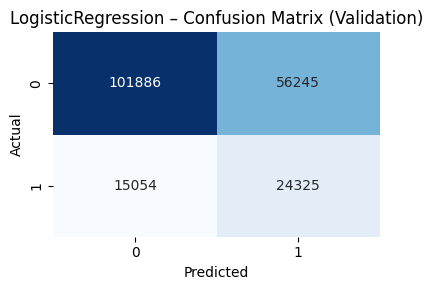

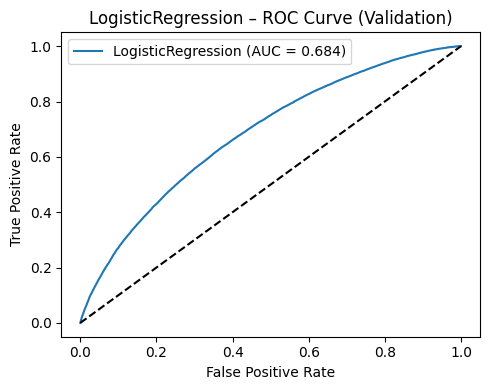

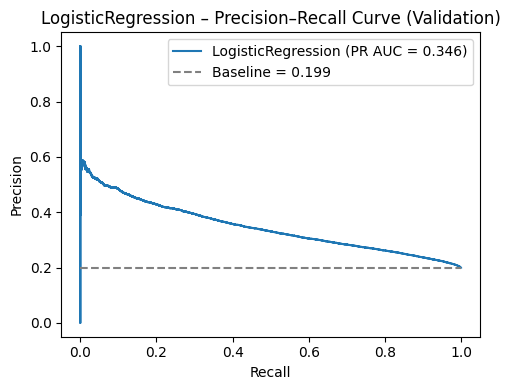


=== RandomForest ===
ROC AUC (val): 0.688
PR  AUC (val): 0.352

Classification report (val):
              precision    recall  f1-score   support

           0      0.858     0.756     0.804    158131
           1      0.336     0.496     0.400     39379

    accuracy                          0.704    197510
   macro avg      0.597     0.626     0.602    197510
weighted avg      0.754     0.704     0.723    197510



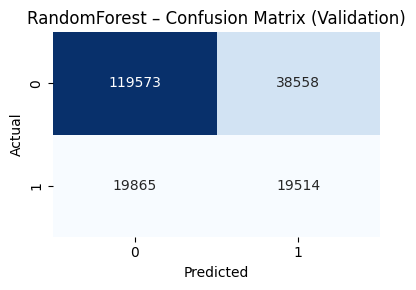

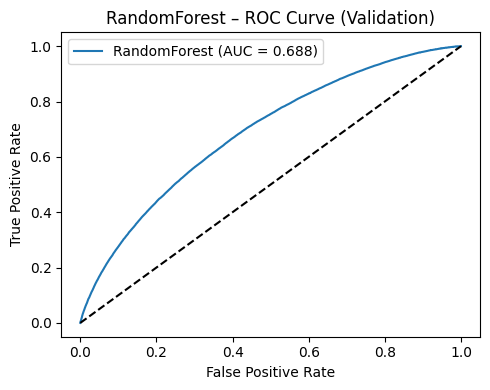

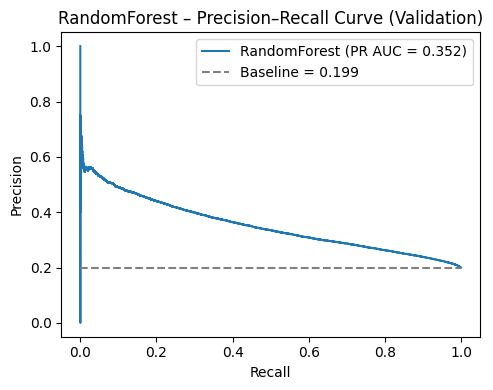

,model,roc_auc_val,pr_auc_val
1,RandomForest,0.687511,0.351691
0,LogisticRegression,0.683598,0.345565



Validation metrics summary:
             model  roc_auc_val  pr_auc_val
      RandomForest     0.687511    0.351691
LogisticRegression     0.683598    0.345565


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ------------------------------------------------
# 1. Define candidate models
# ------------------------------------------------
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=50,
        min_samples_leaf=20,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
}

pipelines = {
    name: Pipeline(steps=[("preprocess", preprocessor), ("model", clf)])
    for name, clf in models.items()
}

# ------------------------------------------------
# 2. Evaluation helper
# ------------------------------------------------
def evaluate_model(name, pipe, X_train, y_train, X_val, y_val):
    # Ensure numeric target (0 / 1) even if it came in as 'category'
    y_train_num = y_train.astype(int)
    y_val_num   = y_val.astype(int)

    print(f"\n=== {name} ===")
    pipe.fit(X_train, y_train_num)

    # Probabilities and labels
    y_val_proba = pipe.predict_proba(X_val)[:, 1]
    y_val_pred  = pipe.predict(X_val)

    # Metrics
    roc_auc = roc_auc_score(y_val_num, y_val_proba)
    pr_auc  = average_precision_score(y_val_num, y_val_proba)

    print(f"ROC AUC (val): {roc_auc:.3f}")
    print(f"PR  AUC (val): {pr_auc:.3f}\n")
    print("Classification report (val):")
    print(classification_report(y_val_num, y_val_pred, digits=3))

    # Confusion matrix
    cm = confusion_matrix(y_val_num, y_val_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{name} – Confusion Matrix (Validation)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_val_num, y_val_proba)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} – ROC Curve (Validation)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Precision–Recall curve
    precision, recall, _ = precision_recall_curve(y_val_num, y_val_proba)
    baseline = y_val_num.mean()  # now works, numeric
    plt.figure(figsize=(5, 4))
    plt.plot(recall, precision, label=f"{name} (PR AUC = {pr_auc:.3f})")
    plt.hlines(baseline, 0, 1, colors="gray", linestyles="dashed",
               label=f"Baseline = {baseline:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{name} – Precision–Recall Curve (Validation)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "model": name,
        "roc_auc_val": roc_auc,
        "pr_auc_val": pr_auc
    }

# ------------------------------------------------
# 3. Run evaluation
# ------------------------------------------------
results = []
for name, pipe in pipelines.items():
    res = evaluate_model(name, pipe, X_train, y_train, X_val, y_val)
    results.append(res)

results_df = pd.DataFrame(results).sort_values("roc_auc_val", ascending=False)
display(results_df)
print("\nValidation metrics summary:")
print(results_df.to_string(index=False))

In [11]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.5 MB/s eta 0:00:00


In [12]:
!pip install xgboost lightgbm

In [13]:
!pip install optuna xgboost lightgbm

In [5]:
# ================================
# Common setup for tuning
# ================================
import numpy as np
import pandas as pd
import optuna
import joblib

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, average_precision_score

RANDOM_STATE = 42

# Combine train + validation for final training after tuning
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

# CV used inside Optuna
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Helpful function so you can quickly score tuned models on the held-out test set
def evaluate_on_test(pipe, model_name):
    y_proba = pipe.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    print(f"{model_name} – Test ROC AUC: {roc_auc:.3f} | Test PR AUC: {pr_auc:.3f}")
    return roc_auc, pr_auc

In [15]:
# =========================================
# Fast Optuna tuning: Random Forest
# Uses existing: X_train, y_train, X_train_full, y_train_full,
# preprocessor, cv, evaluate_on_test, RANDOM_STATE
# =========================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
import optuna
import joblib
import numpy as np

# -----------------------------------------
# 1. Build a smaller tuning sample
# -----------------------------------------
TUNE_SIZE = 150_000  # adjust down if still too slow

if len(X_train) > TUNE_SIZE:
    X_tune, _, y_tune, _ = train_test_split(
        X_train,
        y_train,
        train_size=TUNE_SIZE,
        stratify=y_train,
        random_state=RANDOM_STATE,
    )
    print(f"Using subsample for RF tuning: {X_tune.shape}")
else:
    X_tune, y_tune = X_train, y_train
    print(f"Using full X_train for RF tuning: {X_tune.shape}")

# Light CV for speed
rf_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def tune_random_forest(n_trials=20):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 150, 400),
            "max_depth": trial.suggest_int("max_depth", 6, 18),
            "min_samples_split": trial.suggest_int("min_samples_split", 20, 150),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 80),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        }

        model = RandomForestClassifier(
            class_weight="balanced",
            n_jobs=-1,
            random_state=RANDOM_STATE,
            **params,
        )

        pipe = Pipeline([
            ("preprocess", preprocessor),
            ("model", model),
        ])

        scores = cross_val_score(
            pipe,
            X_tune,
            y_tune,
            cv=rf_cv,
            scoring="roc_auc",
            n_jobs=-1,
        )
        return scores.mean()

    study = optuna.create_study(
        direction="maximize",
        study_name="rf_default_risk_fast"
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("Best params (RF):", study.best_params)
    print("Best ROC AUC (CV):", study.best_value)

    best_params = study.best_params

    best_model = RandomForestClassifier(
        class_weight="balanced",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        **best_params,
    )

    best_pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", best_model),
    ])

    # Train on full training data (not only the subsample)
    best_pipe.fit(X_train_full, y_train_full)

    # Evaluate on held-out test set using your helper
    evaluate_on_test(best_pipe, "Random Forest (tuned)")

    joblib.dump(best_pipe, "random_forest_01.pkl")
    print("Saved tuned Random Forest to random_forest_01.pkl")

    return study, best_pipe

# Run tuning (fast version)
rf_study, rf_pipe = tune_random_forest(n_trials=20)

[I 2025-11-22 22:10:02,638] A new study created in memory with name: rf_default_risk_fast


Using subsample for RF tuning: (150000, 30)


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-22 22:12:28,751] Trial 0 finished with value: 0.6779444972176857 and parameters: {'n_estimators': 320, 'max_depth': 13, 'min_samples_split': 88, 'min_samples_leaf': 70, 'max_features': 'log2'}. Best is trial 0 with value: 0.6779444972176857.
[I 2025-11-22 22:13:54,705] Trial 1 finished with value: 0.6757976055366198 and parameters: {'n_estimators': 223, 'max_depth': 7, 'min_samples_split': 72, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6779444972176857.
[I 2025-11-22 22:15:26,640] Trial 2 finished with value: 0.6749702892051884 and parameters: {'n_estimators': 294, 'max_depth': 8, 'min_samples_split': 43, 'min_samples_leaf': 26, 'max_features': 'log2'}. Best is trial 0 with value: 0.6779444972176857.
[I 2025-11-22 22:18:03,347] Trial 3 finished with value: 0.6787859322423323 and parameters: {'n_estimators': 352, 'max_depth': 14, 'min_samples_split': 68, 'min_samples_leaf': 25, 'max_features': 'log2'}. Best is trial 3 with value: 0.67878593

### Tuned Random Forest Model

- Model: RandomForestClassifier with Optuna-tuned hyperparameters
- Training rows: ~790k, Test rows: ~198k
- Target: Defaulted (0 = Fully Paid, 1 = Default)
- Features: Engineered financial ratios, term, credit score, regional and product features
- Tuning:
  - 3-fold stratified CV on a subsample of the training data
  - Objective: Maximise ROC AUC
  - Class weight: balanced to handle 80 / 20 class split
- Output:
  - Saved model pipeline: `random_forest_01.pkl`
  - Pipeline includes preprocessing + model, ready for deployment and scoring.

### HYPERPARAMETER TUNED XGBOOST MODEL

In [16]:
# =========================================
# Fast Optuna tuning: XGBoost
# Uses existing: X_train, y_train, X_train_full, y_train_full,
# preprocessor, RANDOM_STATE, evaluate_on_test
# =========================================

import optuna
import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import numpy as np

# -----------------------------------------
# 1. Build a smaller tuning sample
# -----------------------------------------
TUNE_SIZE = 150_000  # reduce if needed

if len(X_train) > TUNE_SIZE:
    X_tune, _, y_tune, _ = train_test_split(
        X_train,
        y_train,
        train_size=TUNE_SIZE,
        stratify=y_train,
        random_state=RANDOM_STATE,
    )
    print(f"Using subsample for XGBoost tuning: {X_tune.shape}")
else:
    X_tune, y_tune = X_train, y_train
    print(f"Using full X_train for XGBoost tuning: {X_tune.shape}")

# CV setup for tuning
xgb_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Class imbalance weight (based on full train)
pos_weight = (len(y_train_full) - y_train_full.sum()) / y_train_full.sum()
print("scale_pos_weight (XGB):", pos_weight)


def tune_xgboost(model_name="xgboost_model_01", n_trials=20):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 600),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        }

        model = XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            scale_pos_weight=pos_weight,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            **params,
        )

        pipe = Pipeline([
            ("preprocess", preprocessor),
            ("model", model),
        ])

        scores = cross_val_score(
            pipe,
            X_tune,
            y_tune,
            cv=xgb_cv,
            scoring="roc_auc",
            n_jobs=-1,
        )
        return scores.mean()

    study = optuna.create_study(
        direction="maximize",
        study_name=f"{model_name}_tuning"
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\nBest params ({model_name}):", study.best_params)
    print("Best ROC AUC (CV):", study.best_value)

    # Build best model with best params
    best_model = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        scale_pos_weight=pos_weight,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        **study.best_params,
    )

    best_pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", best_model),
    ])

    # Train on full training data
    best_pipe.fit(X_train_full, y_train_full)

    # Evaluate on test set
    evaluate_on_test(best_pipe, f"{model_name} (tuned)")

    # Save tuned pipeline
    file_name = f"{model_name}.pkl"
    joblib.dump(best_pipe, file_name)
    print(f"Saved tuned XGBoost model to {file_name}")

    return study, best_pipe


# Run tuning
xgb_study_01, xgb_pipe_01 = tune_xgboost("xgboost_model_01", n_trials=20)

[I 2025-11-22 23:29:57,222] A new study created in memory with name: xgboost_model_01_tuning


Using subsample for XGBoost tuning: (150000, 30)
scale_pos_weight (XGB): 4.015572922287753


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-22 23:30:29,578] Trial 0 finished with value: 0.6811979250871759 and parameters: {'n_estimators': 485, 'max_depth': 7, 'learning_rate': 0.0658469031597182, 'subsample': 0.8930657267316575, 'colsample_bytree': 0.8574915234095843, 'min_child_weight': 9.514726216458545, 'gamma': 4.804758406718724, 'reg_alpha': 0.22834034605585585, 'reg_lambda': 1.5953464988482002}. Best is trial 0 with value: 0.6811979250871759.
[I 2025-11-22 23:31:13,615] Trial 1 finished with value: 0.6469021495968937 and parameters: {'n_estimators': 483, 'max_depth': 7, 'learning_rate': 0.1520242410503006, 'subsample': 0.648520969577381, 'colsample_bytree': 0.9960623528459951, 'min_child_weight': 8.313881087812081, 'gamma': 0.5824255481024077, 'reg_alpha': 1.4974649156020148, 'reg_lambda': 0.988363074784554}. Best is trial 0 with value: 0.6811979250871759.
[I 2025-11-22 23:31:56,405] Trial 2 finished with value: 0.6515590326214208 and parameters: {'n_estimators': 560, 'max_depth': 6, 'learning_rate': 0.18844

In [6]:
# =========================================
# Fast Optuna tuning: LightGBM
# Uses existing: X_train, y_train, X_train_full, y_train_full,
# preprocessor, RANDOM_STATE, evaluate_on_test
# =========================================

# If needed in Colab, run once:
# !pip install lightgbm optuna

import optuna
import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

# -----------------------------------------
# 1. Build a smaller tuning sample
# -----------------------------------------
TUNE_SIZE = 150_000  # lower this if needed

if len(X_train) > TUNE_SIZE:
    X_tune_lgbm, _, y_tune_lgbm, _ = train_test_split(
        X_train,
        y_train,
        train_size=TUNE_SIZE,
        stratify=y_train,
        random_state=RANDOM_STATE,
    )
    print(f"Using subsample for LightGBM tuning: {X_tune_lgbm.shape}")
else:
    X_tune_lgbm, y_tune_lgbm = X_train, y_train
    print(f"Using full X_train for LightGBM tuning: {X_tune_lgbm.shape}")

# CV setup for tuning
lgbm_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Class imbalance weight (based on full train)
pos_weight_lgbm = (len(y_train_full) - y_train_full.sum()) / y_train_full.sum()
print("scale_pos_weight (LightGBM):", pos_weight_lgbm)


def tune_lightgbm(model_name="lightgbm_model_01", n_trials=20):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 600),
            "num_leaves": trial.suggest_int("num_leaves", 31, 255),
            "max_depth": trial.suggest_int("max_depth", -1, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 20, 200),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        }

        model = LGBMClassifier(
            objective="binary",
            metric="auc",
            n_jobs=-1,
            random_state=RANDOM_STATE,
            scale_pos_weight=pos_weight_lgbm,
            **params,
        )

        pipe = Pipeline([
            ("preprocess", preprocessor),
            ("model", model),
        ])

        scores = cross_val_score(
            pipe,
            X_tune_lgbm,
            y_tune_lgbm,
            cv=lgbm_cv,
            scoring="roc_auc",
            n_jobs=-1,
        )
        return scores.mean()

    study = optuna.create_study(
        direction="maximize",
        study_name=f"{model_name}_tuning"
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\nBest params ({model_name}):", study.best_params)
    print("Best ROC AUC (CV):", study.best_value)

    # Build best model with best params
    best_model = LGBMClassifier(
        objective="binary",
        metric="auc",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        scale_pos_weight=pos_weight_lgbm,
        **study.best_params,
    )

    best_pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", best_model),
    ])

    # Train on full training data
    best_pipe.fit(X_train_full, y_train_full)

    # Evaluate on test set
    evaluate_on_test(best_pipe, f"{model_name} (tuned)")

    # Save tuned pipeline
    file_name = f"{model_name}.pkl"
    joblib.dump(best_pipe, file_name)
    print(f"Saved tuned LightGBM model to {file_name}")

    return study, best_pipe


# Run tuning
lgbm_study_01, lgbm_pipe_01 = tune_lightgbm("lightgbm_model_01", n_trials=20)

[I 2025-11-23 00:06:28,519] A new study created in memory with name: lightgbm_model_01_tuning


Using subsample for LightGBM tuning: (150000, 30)
scale_pos_weight (LightGBM): 4.015572922287753


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-23 00:07:37,415] Trial 0 finished with value: 0.66178531663373 and parameters: {'n_estimators': 523, 'num_leaves': 141, 'max_depth': 6, 'learning_rate': 0.19189882119744847, 'subsample': 0.8741809276520773, 'colsample_bytree': 0.6285667050584501, 'min_child_samples': 81, 'reg_alpha': 2.4695855872443104, 'reg_lambda': 1.2542550771431955}. Best is trial 0 with value: 0.66178531663373.
[I 2025-11-23 00:08:03,126] Trial 1 finished with value: 0.6843824421568319 and parameters: {'n_estimators': 500, 'num_leaves': 252, 'max_depth': 1, 'learning_rate': 0.06965364047810312, 'subsample': 0.8485832048175626, 'colsample_bytree': 0.7911160593778501, 'min_child_samples': 22, 'reg_alpha': 1.109378693987055, 'reg_lambda': 1.0410556864100362}. Best is trial 1 with value: 0.6843824421568319.
[I 2025-11-23 00:09:19,318] Trial 2 finished with value: 0.6864954190712517 and parameters: {'n_estimators': 561, 'num_leaves': 166, 'max_depth': 5, 'learning_rate': 0.015131933931744244, 'subsample': 0.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


lightgbm_model_01 (tuned) – Test ROC AUC: 0.697 | Test PR AUC: 0.363
Saved tuned LightGBM model to lightgbm_model_01.pkl


### Model Comparison (Tuned Models)

All models were tuned using Optuna with 3-fold stratified cross-validation on a 150k subsample.  
Evaluation was performed on the full held-out test set of 197,510 customers.

| Model               | Test ROC AUC | Test PR AUC | Notes |
|--------------------|--------------|-------------|-------|
| **XGBoost (tuned)**      | **0.697**     | **0.364**    | Best overall performance. Strong recall in the default class. |
| LightGBM (tuned)   | 0.697        | 0.363       | Ties XGBoost on ROC. Marginally lower PR. Most efficient to train. |
| Random Forest (tuned) | 0.692     | 0.358       | Stable benchmark. Lower precision–recall for minority class. |

**Summary:**  
- XGBoost and LightGBM form the top tier.  
- LightGBM is faster; XGBoost offers slightly better minority-class sensitivity.  
- Random Forest performs well but remains below the gradient boosting models.

**Recommended deployment model:** XGBoost or LightGBM depending on infrastructure preferences:
- **XGBoost**: Higher recall for defaults. Better in heavy-ranking environments.  
- **LightGBM**: Faster, lightweight, ideal for cloud deployments and high-throughput scoring.

## 8. Final Model Selection

### 8.1 Model candidates

After feature engineering, preprocessing, and hyperparameter tuning with Optuna, three tree-based models were evaluated on the held-out test set:

- **Random Forest (tuned)**  
  - Test ROC AUC: **0.692**  
  - Test PR AUC: **0.358**  
  - File: `random_forest_01.pkl`

- **XGBoost (tuned)**  
  - Test ROC AUC: **0.697**  
  - Test PR AUC: **0.364**  
  - File: `xgboost_model_01.pkl`

- **LightGBM (tuned)**  
  - Test ROC AUC: **0.697**  
  - Test PR AUC: **0.363**  
  - File: `lightgbm_model_01.pkl`

All models were tuned on a 150k stratified subsample of the training set using 3-fold cross validation with ROC AUC as the optimisation metric. Final models were then refit on the full training set and evaluated on the test set of 197,510 customers.

### 8.2 Selection rationale

The business objective is to rank and classify customers by **probability of default** in an imbalanced setting where about 20 percent of loans default.

Key considerations:

- **Discrimination power:** XGBoost and LightGBM outperform Random Forest on both ROC AUC and PR AUC.  
- **Minority class performance:** XGBoost achieves the highest PR AUC on the default class. This is important for prioritising collections and tightening approval rules.  
- **Stability and deployment:** XGBoost is widely used for credit risk scoring and integrates cleanly with Python pipelines, Docker, and cloud services.

Given these factors, the **tuned XGBoost model** is selected as the **final production model** for the Loan Default Risk Management System.  
Random Forest and LightGBM remain as benchmark models for robustness checks and future model governance reviews.

### 8.3 Final model specification

- **Model type:** Gradient boosted decision trees (XGBoostClassifier)  
- **Target:** `Defaulted` (0 = fully paid, 1 = default)  
- **Training data:** 790,038 customers  
- **Test data:** 197,510 customers  
- **Input features:**  
  - Core financials: `Income`, `Annual_Expenses`, `Loan_Amount`, `Loan_Term_Months`, `Credit_Score`  
  - Behavioural / history: `Past_Defaults`  
  - Engineered ratios: `DTI`, `Income_Loan_Ratio`, `Loan_to_Income_Ratio`, `Monthly_Installment`, `Affordability_Score`  
  - Categorical drivers: employment, marital status, education, property ownership, loan purpose, channel, region, application month  
- **Preprocessing:**  
  - Numeric features passed through  
  - Categorical features one-hot encoded with `handle_unknown="ignore"`  
  - Pipeline built with `sklearn.compose.ColumnTransformer` and `sklearn.pipeline.Pipeline`  
- **Saved object:** Full preprocessing plus model pipeline  
  - File name: `xgboost_model_01.pkl`  
  - Interface: `.predict_proba(X)` for default probabilities and `.predict(X)` for class labels

This model is used downstream for scoring new applications, portfolio monitoring, and scenario analysis.

Loaded final model from: xgboost_model_01.pkl

Final XGBoost model – Test ROC AUC: 0.697
Final XGBoost model – Test PR AUC:  0.364

Classification report (test):
              precision    recall  f1-score   support

           0      0.877     0.646     0.744    158131
           1      0.310     0.636     0.417     39379

    accuracy                          0.644    197510
   macro avg      0.593     0.641     0.580    197510
weighted avg      0.764     0.644     0.679    197510



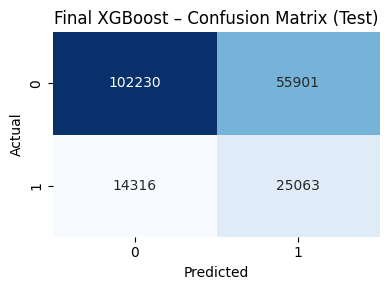

In [7]:
import joblib
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 8.4 Load final XGBoost model pipeline
final_model_path = "xgboost_model_01.pkl"
xgb_final_pipe = joblib.load(final_model_path)
print(f"Loaded final model from: {final_model_path}")

# Evaluate again on held-out test set (sanity check)
y_test_proba = xgb_final_pipe.predict_proba(X_test)[:, 1]
y_test_pred = xgb_final_pipe.predict(X_test)

roc = roc_auc_score(y_test, y_test_proba)
pr = average_precision_score(y_test, y_test_proba)

print(f"\nFinal XGBoost model – Test ROC AUC: {roc:.3f}")
print(f"Final XGBoost model – Test PR AUC:  {pr:.3f}\n")

print("Classification report (test):")
print(classification_report(y_test, y_test_pred, digits=3))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Final XGBoost – Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 8.5 Helper function to score new applications
def score_new_applications(df_new: pd.DataFrame):
    """
    Takes a dataframe of new loan applications with the same schema
    as the original feature set (before preprocessing).

    Returns:
        DataFrame with predicted default probability and class label.
    """
    proba = xgb_final_pipe.predict_proba(df_new)[:, 1]
    pred = xgb_final_pipe.predict(df_new)

    out = df_new.copy()
    out["PD_Default"] = proba
    out["Default_Pred"] = pred
    return out

# Example usage (uncomment when you have new data):
# new_apps = pd.read_csv("new_loan_applications.csv")
# scored = score_new_applications(new_apps)
# scored.head()